# dependencies

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Plot Parameters

In [2]:
# Set font sizes globally
plt.rcParams['font.size'] = 16  # General font size
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 18  # Label font size (xlabel, ylabel)
plt.rcParams['xtick.labelsize'] = 14  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 16  # Legend font size

# functions

In [3]:
# Function to read CSV file and extract data
def read_data_from_csv(L):
    filename = f"Data_single/c_d_data_L_{L}_t_steps_100.csv"
    temperatures = []
    squared_magnetizations = []
    susceptibilities = []
    errors_m2 = []
    errors_chi = []

    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        for row in reader:
            temp, m2, chi, err_m2, err_chi = map(float, row)
            temperatures.append(temp)
            squared_magnetizations.append(m2)
            susceptibilities.append(chi)
            errors_m2.append(err_m2)
            errors_chi.append(err_chi)

    return np.array(temperatures), np.array(squared_magnetizations), np.array(susceptibilities), np.array(errors_m2), np.array(errors_chi)

# Extract T_C(L) by finding the temperature where susceptibility is maximum
def find_critical_temperature(temperatures, susceptibilities):
    max_chi_index = np.argmax(susceptibilities)
    return temperatures[max_chi_index]

# Function for fitting the scaling of T_C(L)
def scaling_func(L, T_C, const):
    L_float = np.float64(L)  # Ensuring L is treated as a float
    return T_C + const * L_float**(-1)

# Function for fitting the scaling of chi_star vs L
def scaling_chi_func(L, scaling_factor):
    return scaling_factor * L**(1.75)

# (a)

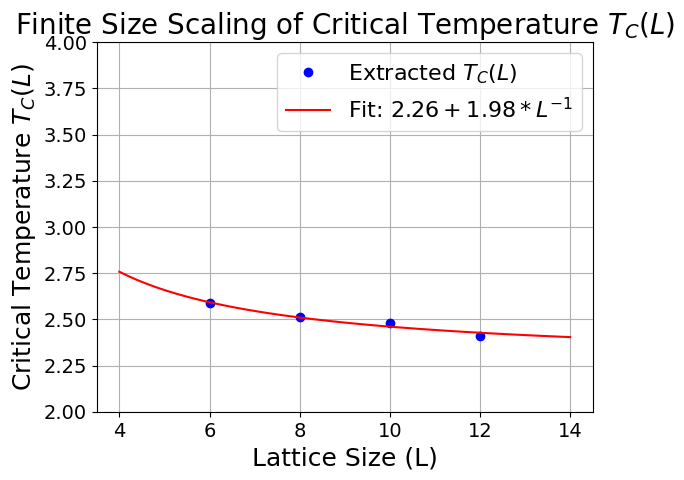

Fitted T_C (infinite system): 2.2622257912042243
Exact T_C value: 2.269185314213022
Difference from exact T_C (2.269185314213022): -0.006959523008797763


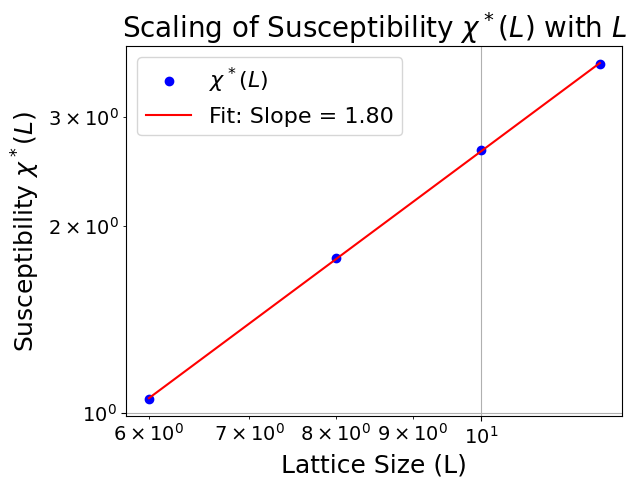

Fitted slope (gamma/nu): 1.798816741885351
Fitted gamma: 1.798816741885351
Difference between measured and expected gamma (1.75): 0.0488167418853509


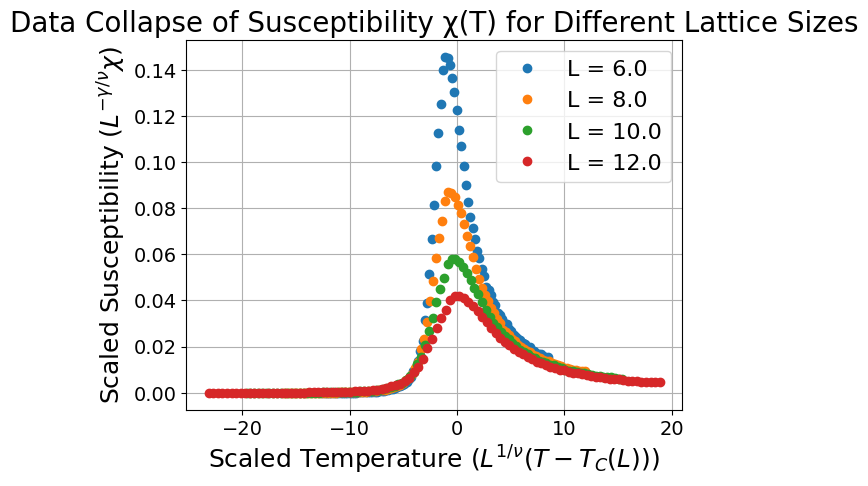

In [11]:
Ls = [6,8,10,12]

# Initialize lists to store extracted data
T_C_values = []
chi_star_values = []
L_values = []

# Read and process data for each L
for L in Ls:
    temperatures, squared_magnetizations, susceptibilities, errors_m2, errors_chi = read_data_from_csv(L)

    # Find T_C(L) by finding the maximum of the susceptibility
    T_C_L = find_critical_temperature(temperatures, susceptibilities)
    chi_star_L = susceptibilities[np.argmax(susceptibilities)]  # Chi at T_C(L)

    # Append to lists
    T_C_values.append(T_C_L)
    chi_star_values.append(chi_star_L)
    L_values.append(L)

# Fit T_C(L) scaling with L^{-1}
L_values = np.array(L_values)
T_C_values = np.array(T_C_values)
params, _ = curve_fit(scaling_func, L_values.astype(float), T_C_values)  # Ensure L_values are treated as floats
T_C_infinite = params[0]  # This is the fitted value for T_C (infinite system)
scaling_const = params[1]

# Plot scaling of T_C(L)
l_vals = np.linspace(L_values[0]-2, L_values[-1]+2, 50)
plt.plot(L_values, T_C_values, 'bo', label='Extracted $T_C(L)$')
plt.plot(l_vals, scaling_func(l_vals.astype(float), *params), 'r-', label=f"Fit: ${T_C_infinite:.2f} + {scaling_const:.2f} *$" + "$L^{-1}$")
plt.xlabel("Lattice Size (L)")
plt.ylabel("Critical Temperature $T_C(L)$")
plt.legend()
plt.ylim(2,4)
plt.title("Finite Size Scaling of Critical Temperature $T_C(L)$")
plt.grid(True)

plt.savefig("Plots02/a_TC_fit.png", bbox_inches= "tight")
plt.show()

# The exact value of T_C for the 2D Ising model is approximately 2.269
exact_T_C = 2 / np.log(1 + np.sqrt(2))
print(f"Fitted T_C (infinite system): {T_C_infinite}")
print(f"Exact T_C value: {exact_T_C}")
print(f"Difference from exact T_C ({exact_T_C}): {T_C_infinite - exact_T_C}")

# Now let's fit the chi_star values to extract the scaling exponent gamma
plt.loglog(L_values, chi_star_values, 'bo', label='$\chi^*(L)$')

# Perform log-log fit
log_L = np.log(L_values)
log_chi_star = np.log(chi_star_values)
slope, intercept = np.polyfit(log_L, log_chi_star, 1)

# The expected value for gamma/nu is 1.75, and we extract gamma (since nu = 1)
gamma = slope

# Plot the fitted line for chi_star scaling
plt.loglog(L_values, np.exp(intercept) * L_values**slope, 'r-', label=f"Fit: Slope = {slope:.2f}")
plt.xlabel("Lattice Size (L)")
plt.ylabel("Susceptibility $\chi^*(L)$")
plt.legend()
plt.title("Scaling of Susceptibility $\chi^*(L)$ with $L$")
plt.grid(True)

plt.savefig("Plots02/b_chi_fit.png", bbox_inches= "tight")
plt.show()

print(f"Fitted slope (gamma/nu): {slope}")
print(f"Fitted gamma: {gamma}")
print(f"Difference between measured and expected gamma (1.75): {gamma-1.75}")

# Perform data collapse
def data_collapse(T, L, T_C_L, gamma, nu=1):
    scaled_chi = (L**(-gamma/nu)) * np.interp(T, temperatures, susceptibilities)  # Use interpolation for chi(T)
    scaled_T = (T - T_C_L) * L**(1/nu)
    return scaled_T, scaled_chi

# Store all scaled points to plot later
scaled_points = []

# Perform data collapse for each L
for L in L_values.astype(float):
    scaled_t_array = []
    scaled_chi_array = []
    T_C_L = T_C_infinite + scaling_const * L**(-1)
    for T in temperatures:
        scaled_T, scaled_chi = data_collapse(T, L, T_C_L, gamma)

        scaled_chi_array.append(scaled_chi)
        scaled_t_array.append(scaled_T)

        scaled_points.append((scaled_T, scaled_chi))
    plt.plot(scaled_t_array, scaled_chi_array, label = f"L = {L}", marker = "o", ls = '')
# Now plot all scaled points at once
# for scaled_T, scaled_chi in scaled_points:
#     plt.plot(scaled_T, scaled_chi, 'o')

plt.xlabel("Scaled Temperature ($L^{1/ν} (T - T_C(L)))$")
plt.ylabel("Scaled Susceptibility ($L^{-γ/ν}\chi$)")
plt.legend()
plt.title("Data Collapse of Susceptibility χ(T) for Different Lattice Sizes")
plt.grid(True)

plt.savefig("Plots02/c_data_collapse.png", bbox_inches= "tight")
plt.show()
